# PI de Algotrading - Antonio Fuziy

___

## Introdução

Os indicadores técnicos apresentam um papel fundamental para estudos de mercado, principalmente para o mercado de trade, eles podem ser definidos como heurísticas ou padrões baseados em sinais produzidos por dados de um ativo, como volatilidade, preço, volume e muitos outros. Este relatório tem como objetivo, mostrar alguns indicadores técnicos e fundi-los em uma estratégia de algotrading, dessa forma é possível prever comportamentos futuros de três ativos através desses indicadores.

Para que esse estudo fosse possível, utilizou-se a linguagem de programação Python e a ferramente mais utilizada para esse relatório foi a biblioteca `pandas-ta`, uma biblioteca derivada do `pandas`, porém voltada para análise técnica através de indicadores.

Para esse documento utilizou-se três indicadores técnicos, dentre eles estão: 
- Chande Momentum Oscillator **(CMO)**

- Percentage Price Oscillator **(PPO)**

- Bollinger Bands **(BBANDS)**

___

## Metodologia

Esses três indicadores são classificados em categorias, sendo o **CMO** e o **PPO** indicadores de **Momentum** enquanto o **Bollinger Bands** é classificado como indicador de **Volatilidade**.

Os indicadores de Momentum são indicadores técnicos que determinam subidas ou caídas de ativos enquanto os indicadores de Volatilidade determinam trades ótimos de saída ou entrada, identificando casos de muita variação de preço seja ela alta ou baixa.

Entrando mais a fundo nos indicadores escolhidos para o estudo é importante descrever como cada um funciona. Portanto, segue abaixo a explicação de cada indicador:

### Percentage Price Oscillator (PPO)

O PPO utiliza duas médias móveis exponenciais (EMAs) uma de longo prazo (um período de 26 dias) e outra de curto prazo (um período de 12 dias) para calcular a diferença em porcentagem entre as duas EMAs. Seu cálculo é muito similar ao MACD, porém o MACD utiliza a diferença absoluta das duas médias móveis exponenciais. Seu cálculo pode ser identificado pela fórmula abaixo:

![ppo.png](ppo.png)

O PPO gera sinais compra e de venda, para conseguir esses sinais o PPO utiliza uma linha de sinal, gerada através de uma média móvel exponencial calculada em um período de 9 dias em relação a linha de PPO. Por conseguinte, quando o valor do PPO está acima de zero significa que a linha da EMA de curto prazo cruzou acima da EMA de longo prazo, identificando tendência de subida do ativo, da mesma forma, quando o valor do PPO está abaixo de zero significa que a EMA de curto prazo cruzou abaixo da EMA de longo prazo gerando tendêndia de queda do valor do ativo. **Dessa forma, na estratégia desse relatório, quando o PPO está acima de zero e seu valor é maior que o valor da linha de sinal, gera-se um sinal positivo, ou seja, de compra, ao passo em que quando o PPO está abaixo de zero e seu valor é menor que o valor da linha de sinal, gera-se um sinal negativo, ou seja, de venda.**


### Chande Momentum Oscillator (CMO)

O CMO mapeia momentos de sobrecompra e sobrevenda, ele é calculado através da diferença entre a soma de ganhos e perdas recentes dividido pela soma dos ganhos recentes e as perdas recentes, por fim multiplica-se o resultado da divisão por 100, portanto identifica-se a seguinte fórmula:

![cmo.png](cmo.png)

O valor do CMO pode variar de -100 a 100, quando seu valor encontra-se acima de 50 identifica-se um cenário de sobrecompra, ou seja, uma inversão do cenário do mercado, portanto uma possível queda dos preços, ao passo em que quando o CMO apresenta valores abaixo de -50 identifica-se um cenário de sobrevenda, dessa forma preve-se que o mercado aumentará os preços. **Por conseguinte, para a estratégia desse relatório quando o valor do CMO é maior que 50 gera-se um sinal negativo para esse indicador, indicando a venda do ativo, ao passo em que quando o CMO é menor que -50 o sinal do indicador agora é positivo, gerando a compra do ativo.**

### Bollinger Bands (BBANDS)

O indicador técnico Bollinger Bands identifica linhas de tendência e pode ser considerado um indicador de volatilidade, para que ele exista calculam-se uma média móvel dos preços e duas bandas de preços, essas bandas são calculadas através de dois desvios padrões, um sendo positivo e outro negativo, pode-se verificar esse cálculo através da fórmula abaixo:

![bbands.png](bbands.png)

Para gerar sinais esse indicador se modifica conforme os preços atingem as bandas, portanto quanto mais o preço do ativo chega perto da banda superior mais se aproxima de um cenário de sobrecompra do mercado e quanto mais o preço do ativo se aproxima da banda inferior mais perto o ativo está de um cenário de sobrevenda. **Portanto para a estratégia desse relatório quando o valor dos preços atinge a banda superior gera-se um sinal negativo, ou seja, indica-se a venda do ativo, ao passo em que quando os preços atingem a banda inferior gera-se um sinal positivo, ou seja, indica-se a compra do ativo.**

### Fuziy Strategy

Nessa seção do relatório será abordado a ideia por traz da estratégia construída através dos indicadores técnicos citados anteriormente. Portanto, a estratégia `Fuziy Strategy` utiliza três indicadores técnicos, o Chande Momentum Oscillator, Percentage Price Oscillator e o Bollinger Bands. O primeiro passo dessa estratégia é observar os valores de fechamento de preço do dia anterior, assim através deles calcula-se os indicadores e gera-se os sinais de cada indicador, portanto fundindo esses sinais toma-se a decisão de compra, venda ou não faz nada. 

- Para o CMO, quando o seu valor ultrapassa de 50 gera-se um sinal negativo (-1) e caso seu valor seja -50 o sinal gerado é positivo (+1). 

- Olhando para o PPO quando o seu valor é maior que zero e maior que o valor da linha de sinal, gera-se um sinal positivo (+1), ao passo em que quando o valor do PPO é menor que zero e menor que a linha de sinal, o sinal agora é negativo (-1).

- Para o Bollinger Bands, quando o valor do preço do ativo chega ao valor da banda superior, gera-se um sinal negativo (-1), ao passo em que quando o valor do preço do ativo atinge o valor da banda inferior o sinal agora é positivo (+1).

**Os sinais positivos ou negativos para cada indicador individualmente não geram ordens de compra ou venda, apenas as combinações entre eles geram essas ações, a combinação dos indicadores é feita através da soma dos três valores de sinais gerados por eles, portanto quando o valor da soma dos indicadores é +2 e não encontra-se em um cenário de alocação é gerado a ordem de compra do ativo, ao mesmo tempo, quando a soma dos indicadores é -2 e não encontra-se em alocação o sinal de venda é gerado, ativando a ordem de venda do ativo.** 

Logo abaixo está o código com o algoritmo por traz de toda estratégia explicada acima. O algoritmo foi simulado com três ativos diferentes em um histórico de 5 anos para o backtesting utilizando um `init_capital` de 1000 dólares, dentre eles estão a Tesla Inc. (TSLA), Meta (META) e Nike Inc. (NKE). Os resultados dessas simulações podem ser observados mais abaixo durante a execução do algoritmo e na conclusão.

Importando as bibliotecas utilizadas 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random
import yahoofinancials as yf
import pandas_ta as ta
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as st
import pandas.testing as tm
from statsmodels.tsa.stattools import adfuller
import scipy.optimize as sco

from backtesting_v2_2 import evaluateHist, evaluateIntr, Strategy, Order, TradingSystem, MarketData, Event

plt.style.use("dark_background")

In [2]:
tickers = ["KO", "PEP"]

In [3]:
start_date = '2017-03-06'
end_date =  '2022-03-06'

for ticker in tickers:
    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    raw = raw.set_index('formatted_date')
    df = raw.iloc[:,1:]
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    df.to_csv('{}.csv'.format(ticker))

In [4]:
df = pd.read_csv('{}.csv'.format(ticker))
df.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2017-03-06,109.800003,110.190002,109.430000,109.629997,91.547104,4491000
1,2017-03-07,109.160004,109.769997,109.000000,109.320000,91.288239,4361100
2,2017-03-08,109.169998,109.330002,108.470001,109.300003,91.271545,5244500
3,2017-03-09,109.599998,109.610001,108.910004,109.019997,91.037712,4066900
4,2017-03-10,109.580002,109.709999,109.279999,109.589996,91.513702,3488900


In [5]:
def get_indicator(prices, array_indicator, indicator, period, side):
    signal_indicator = 0
    ppo_fast = 12
    ppo_slow = 26
    ppo_signal = 9
    ppo_scalar = 100
    ppo_signal = 0
    m = 0
    
    if indicator == "CMO":
        if len(prices) >= period + 1:
            close = pd.DataFrame({'close': prices})
            cmo = close.ta.cmo(length=period)
            array_indicator.append([cmo.iloc[-1]])

            cmo_value = cmo.iloc[-1]

            if cmo_value >= 50: 
                signal_indicator = -1
            elif cmo_value <= -50:
                signal_indicator = 1
            else:
                signal_indicator = 0
    
    if indicator == "PPO":
        if len(prices) >= ppo_slow + ppo_signal:
            close = pd.DataFrame({'close': prices})

            ppo = close.ta.ppo(fast=ppo_fast, slow=ppo_slow, signal=ppo_signal, scalar=ppo_scalar)

            array_indicator.append([ppo.iloc[-1, 0], ppo.iloc[-1, 2]])

            signal_indicator = ppo.iloc[-1, 0] > ppo.iloc[-1, 2]
            
    if indicator == "BBANDS":
        if len(prices) >= period + 1:
            close = pd.DataFrame({'close': prices})
            
            bbands = close.ta.bbands(lenght = period, std = m)            
            
            down = bbands.iloc[-1, 0]
            avg = bbands.iloc[-1, 1]
            up = bbands.iloc[-1, 2]
            
            array_indicator.append([up, avg, down])

            if prices[-1] < down:
                bbands_signal = -1 
            elif prices[-1] > up:
                bbands_signal = 1
            elif prices[-1] > avg and side == -1:
                bbands_signal = 0
            elif prices[-1] < avg and side == 1:
                bbands_signal = 0
            else:
                bbands_signal = side

    return signal_indicator, array_indicator

In [6]:
class FuziyStrategy(Strategy):

    def __init__(self, ticker1, ticker2):
        self.period = 14
        
        self.sell_signals1 = []
        self.buy_signals1 = []
        self.sell_indexes1 = []
        self.buy_indexes1 = []
        
        self.sell_signals2 = []
        self.buy_signals2 = []
        self.sell_indexes2 = []
        self.buy_indexes2 = []

        self.prices1 = []
        self.prices2 = []
        
        self.coint_indicator = []
        self.coint_signal = 0
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        
        self.tam = 30
        
        self.side = 0
        self.signal = 0
        
        self.bbands_indicator1 = []
        self.bbands_indicator2 = []
        self.bbands_signal1 = 0
        self.bbands_signal2 = 0
        
        self.qty1 = 0
        self.qty2 = 0
        
        #====================================================================
        #CMO PARAMETERS
        #====================================================================
        self.cmo_indicator1 = []
        self.cmo_indicator2 = []
        self.cmo_signal1 = 0
        self.cmo_signal2 = 0
        
        #====================================================================
        #PPO PARAMETERS
        #====================================================================
        self.ppo_fast = 12
        self.ppo_slow = 26
        self.ppo_signal = 9
        self.ppo_scalar = 100
        self.ppo_indicator1 = []
        self.ppo_indicator2 = []
        self.ppo_signal1 = 0
        self.ppo_signal2 = 0
        
        self.init_capital = 100000
        self.avail_capital = self.init_capital
        
        self.combined_signals = 0
        
    def receive(self, event):
        
        orders = []
        
        if event.instrument == self.ticker1:
            self.prices1.append(event.price[3])
        elif event.instrument == self.ticker2:
            self.prices2.append(event.price[3])
        
        # Precisa sincronizar os preços
        tam = min(len(self.prices1), len(self.prices2))
        if tam >= self.tam and len(self.prices1) == len(self.prices2):
            
            y = self.prices1[-self.tam:]
            x = self.prices2[-self.tam:]
            
            # Teste da cointegração
            _, pvalue, _ = coint(x, y)
#             self.indicator1.append(pvalue)
            
            # Regressão
            model = st.OLS(y,x)
            results = model.fit()
            
            self.coint_indicator.append(results.resid[-1])
            
            self.coint_signal = self.side
            
            if self.coint_signal < 0 and results.resid[-1] < 0: # Condição para zerar
                self.coint_signal = 0
            elif self.coint_signal > 0 and results.resid[-1] > 0: # Condição para zerar
                self.coint_signal = 0
                
            elif pvalue < 1 and len(self.coint_indicator) > self.tam: # Condição para entrar
                
                # Usando uma espécie de Bollinger Bands, a média será zero por construção
                if results.resid[-1] < -2*np.std(self.coint_indicator[-self.tam:]):
                    self.coint_signal = 1
                elif results.resid[-1] > 2*np.std(self.coint_indicator[-self.tam:]):
                    self.coint_signal = -1
        
            self.cmo_signal1, self.cmo_indicator1 = get_indicator(self.prices1, self.cmo_indicator1, "CMO", self.period, self.side)
            self.cmo_signal2, self.cmo_indicator2 = get_indicator(self.prices2, self.cmo_indicator2, "CMO", self.period, self.side)
    
#             self.ppo_signal1, self.ppo_indicator1 = get_indicator(self.prices1, self.ppo_indicator1, "PPO", self.period, self.side)
#             self.ppo_signal2, self.ppo_indicator2 = get_indicator(self.prices2, self.ppo_indicator2, "PPO", self.period, self.side)

#             self.bbands_signal1, self.bbands_indicator1 = get_indicator(self.prices1, self.bbands_indicator1, "BBANDS", self.period, self.side)
#             self.bbands_signal2, self.bbands_indicator2 = get_indicator(self.prices2, self.bbands_indicator2, "BBANDS", self.period, self.side)
    
            self.combined_signals = self.cmo_signal1 + self.cmo_signal2 + self.ppo_signal1 + self.ppo_signal2 + self.bbands_signal1 + self.bbands_signal2 + self.coint_signal
            # COMBINATION OF SIGNS
            if self.combined_signals >= 2:
                self.signal = 1
#                 print("2 cmo signals")
            elif self.combined_signals <= -2:
#                 print("-2 signals")
                self.signal = -1
            else:
                self.signal = 0
                    
            if self.side != self.signal:
                
                # Zeragem ticker1:
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.S, self.qty1, 0))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                
                # Zeragem ticker2:
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.S, self.qty2, 0))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
                    
                # Cálculo das novas quantidades corretas
                self.qty2 = 200 * self.signal
                self.qty1 = -int(200 / results.params[0]) * self.signal
                
#                 print(results.params[0])
               
                # Montagem da posição
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
#                     print(f"compra {self.ticker1} +{self.qty1}")
#                     print(f"price: {self.prices1[-1]} index: {len(self.prices1)}")
                    self.buy_signals1.append(self.prices1[-1])
                    self.buy_indexes1.append(len(self.prices1))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.SS, self.qty1, 0))
#                     print(f"vende {self.ticker1} -{self.qty1}")
#                     print(f"price: {self.prices1[-1]} index: {len(self.prices1)}")
                    self.sell_signals1.append(self.prices1[-1])
                    self.sell_indexes1.append(len(self.prices1))
                
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
#                     print(f"compra {self.ticker2} +{self.qty2}")
#                     print(f"price: {self.prices2[-1]} index: {len(self.prices2)}")
                    self.buy_signals2.append(self.prices2[-1])
                    self.buy_indexes2.append(len(self.prices2))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.SS, self.qty2, 0))
#                     print(f"vende {self.ticker2} -{self.qty2}")
#                     print(f"price: {self.prices2[-1]} index: {len(self.prices2)}")
                    self.sell_signals2.append(self.prices2[-1])
                    self.sell_indexes2.append(len(self.prices2))

                self.side = self.signal                
            
    def fill(self, id, instrument, price, quantity, status):
        
        # Imprimindo o preenchimento das ordens
        if quantity != 0:
            print('Fill: {0} {1}@{2}'.format(instrument, quantity, price))

In [7]:
fuziy_strategy = FuziyStrategy('KO', 'PEP')

print(evaluateHist(fuziy_strategy, {'KO': 'KO.csv', 'PEP': 'PEP.csv'}))

Fill: KO 526@37.51588439941406
Fill: PEP -200@98.14405059814453
Fill: KO -526@37.59849548339844
Fill: PEP 200@98.41455078125
Fill: KO 514@39.04072952270508
Fill: PEP -200@96.90190124511719
Fill: KO -514@38.71331024169922
Fill: PEP 200@96.68174743652344
Fill: KO -514@36.48282241821289
Fill: PEP 200@93.908203125
Fill: KO 514@37.21924591064453
Fill: PEP -200@95.42572021484375
Fill: KO 499@52.05033493041992
Fill: PEP -200@130.0443572998047
Fill: KO -499@51.9328727722168
Fill: PEP 200@128.91970825195312
Fill: KO -493@48.327938079833984
Fill: PEP 200@119.7500228881836
Fill: KO 493@50.5234260559082
Fill: PEP -200@124.78382110595703
Fill: KO -499@34.907325744628906
Fill: PEP 200@94.90007019042969
Fill: KO 499@35.95545196533203
Fill: PEP -200@103.94902038574219
Gross Profit: $1453.09
Gross Loss: $-285.54
Gross Total: $1167.55

Number of trades: 6
Hitting Ratio: 33.33%
Number of profit trades: 2
Number of loss trades: 4
Average number of events per trade: 2.83

Max win trade: $1286.78
Avg win tr

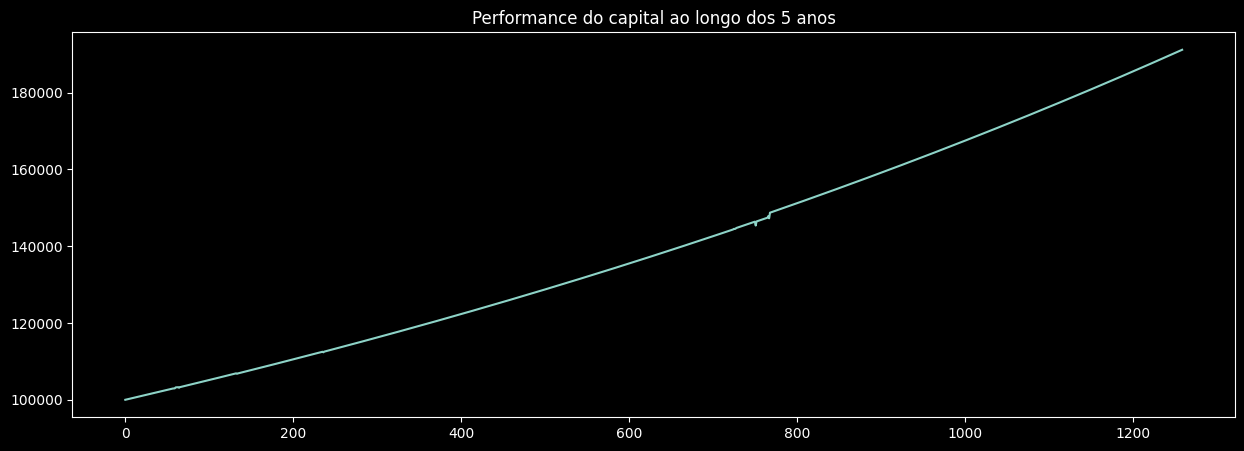

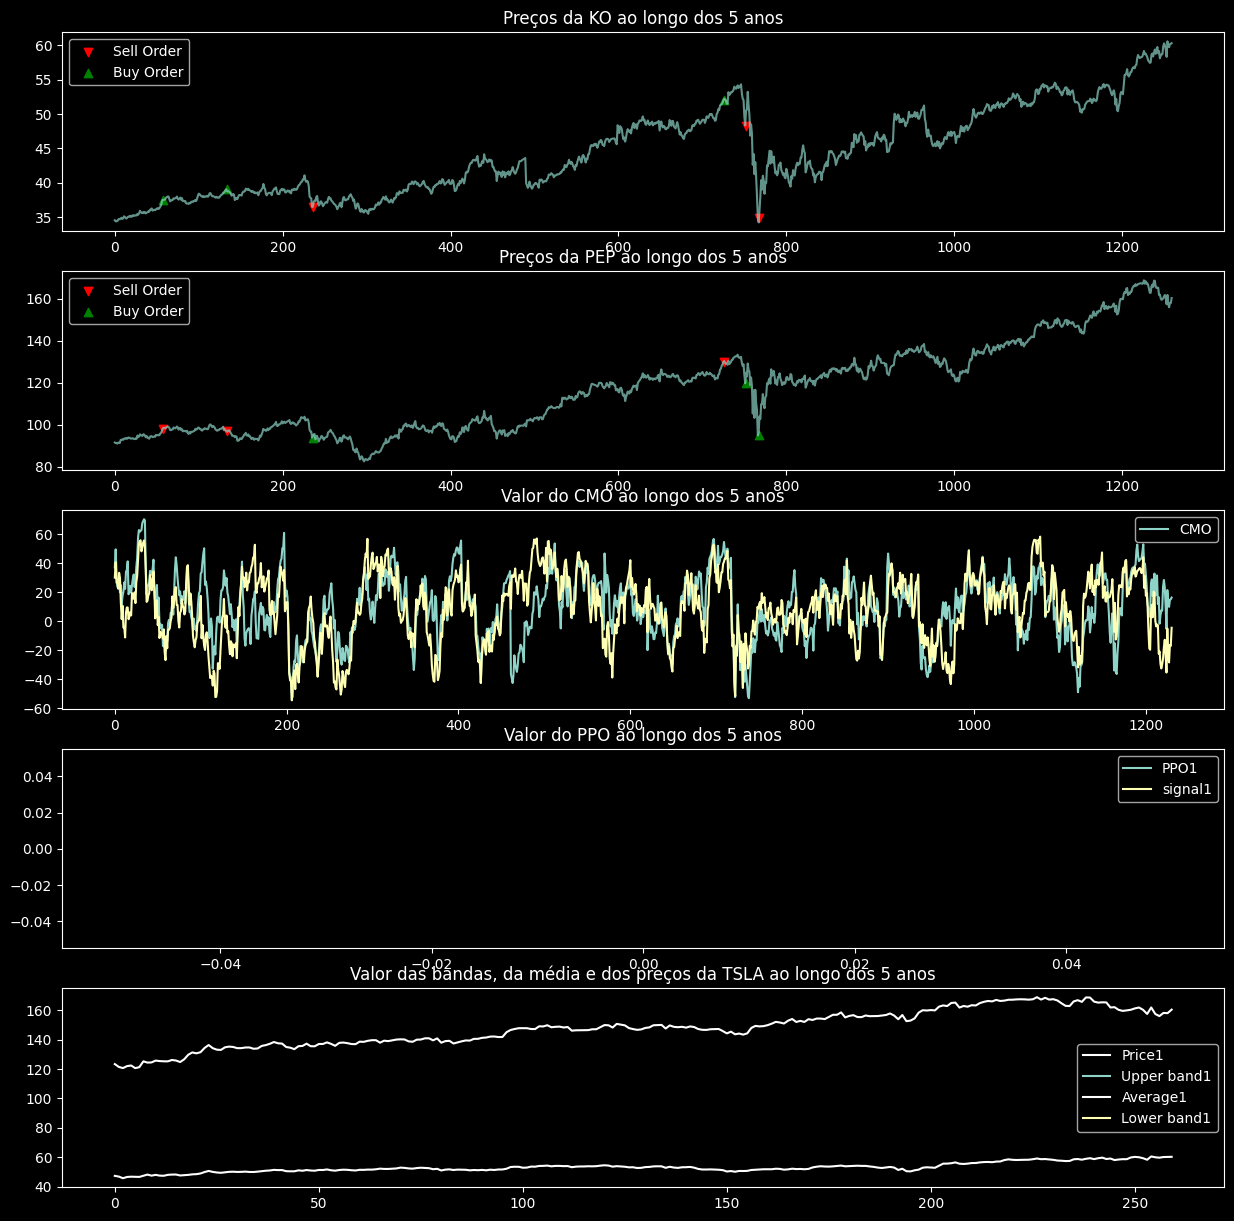

In [8]:
plt.figure(figsize=(15,5))
plt.plot([day[0] for day in fuziy_strategy._days.values()])
plt.title("Performance do capital ao longo dos 5 anos")
plt.show()

plt.figure(figsize=(15,15))

plt.subplot(5,1,1)
plt.plot(fuziy_strategy.prices1, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes1, fuziy_strategy.sell_signals1, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes1, fuziy_strategy.buy_signals1, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da KO ao longo dos 5 anos")

plt.subplot(5,1,2)
plt.plot(fuziy_strategy.prices2, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes2, fuziy_strategy.sell_signals2, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes2, fuziy_strategy.buy_signals2, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da PEP ao longo dos 5 anos")

plt.subplot(5,1,3)
plt.plot(fuziy_strategy.cmo_indicator1)
plt.plot(fuziy_strategy.cmo_indicator2)
plt.legend(['CMO']);
plt.title("Valor do CMO ao longo dos 5 anos")

plt.subplot(5,1,4)
plt.plot(fuziy_strategy.ppo_indicator1)
plt.plot(fuziy_strategy.ppo_indicator2)
plt.legend(['PPO1', 'signal1', 'PPO2', 'signal2']);
plt.title("Valor do PPO ao longo dos 5 anos")

plt.subplot(5,1,5)
plt.plot(fuziy_strategy.prices1[1000:1260], color='white');
plt.plot(fuziy_strategy.bbands_indicator1[1000:1260]);
plt.plot(fuziy_strategy.prices2[1000:1260], color='white');
plt.plot(fuziy_strategy.bbands_indicator2[1000:1260]);
plt.legend(['Price1', 'Upper band1', 'Average1', 'Lower band1', 'Price2', 'Upper band2', 'Average2', 'Lower band2']);
plt.title("Valor das bandas, da média e dos preços da TSLA ao longo dos 5 anos")

plt.show()

In [9]:
fuziy_strategy = FuziyStrategy('META', 'NKE')

print(evaluateHist(fuziy_strategy, {'META': 'META.csv', 'NKE': 'NKE.csv'}))

Fill: META 95@193.25999450683594
Fill: NKE -200@83.9786376953125
Fill: META -95@193.39999389648438
Fill: NKE 200@84.23760986328125
Fill: META 87@229.97000122070312
Fill: NKE -200@90.11042022705078
Fill: META -87@232.1999969482422
Fill: NKE 200@93.6683120727539
Fill: META 78@303.9100036621094
Fill: NKE -200@108.39253997802734
Fill: META -78@293.2200012207031
Fill: NKE 200@107.72193908691406
Fill: META -94@237.75999450683594
Fill: NKE 200@142.8862762451172
Fill: META 94@232.0
Fill: NKE -200@143.82041931152344
Gross Profit: $728.27
Gross Loss: $-1255.76
Gross Total: $-527.50

Number of trades: 4
Hitting Ratio: 25.00%
Number of profit trades: 1
Number of loss trades: 3
Average number of events per trade: 2.75

Max win trade: $728.27
Avg win trade: $728.27
Max loss trade: $-699.70
Avg loss trade: $-418.59
Avg all trades: $-131.87
Win/Loss ratio: 1.74

Max Profit: $1619.09
Max Profit High/Low: $2298.09
Max Drawdown: $-833.82
Max Drawdown High/Low: $-1506.91

Max Allocation: $28035.82
Avg All

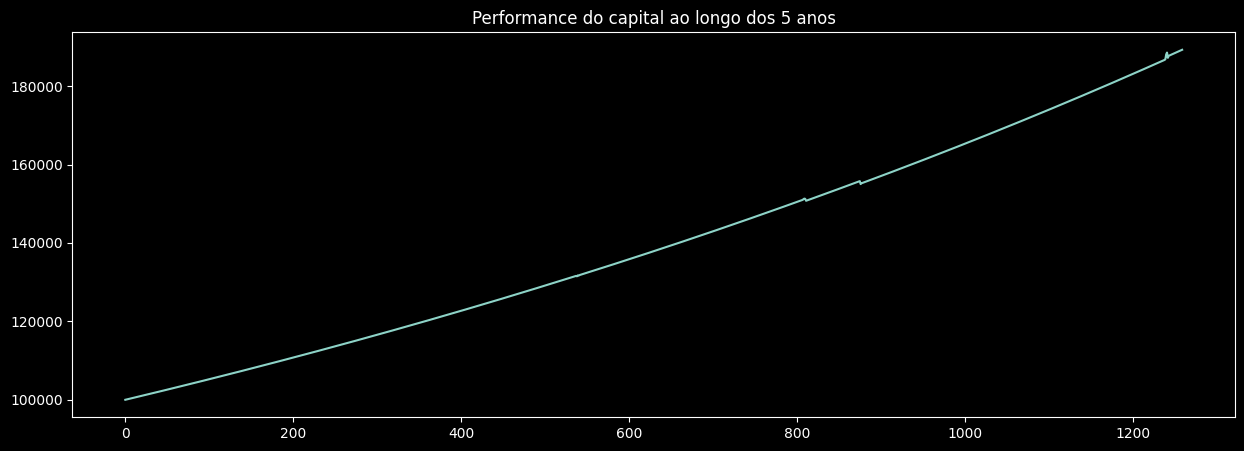

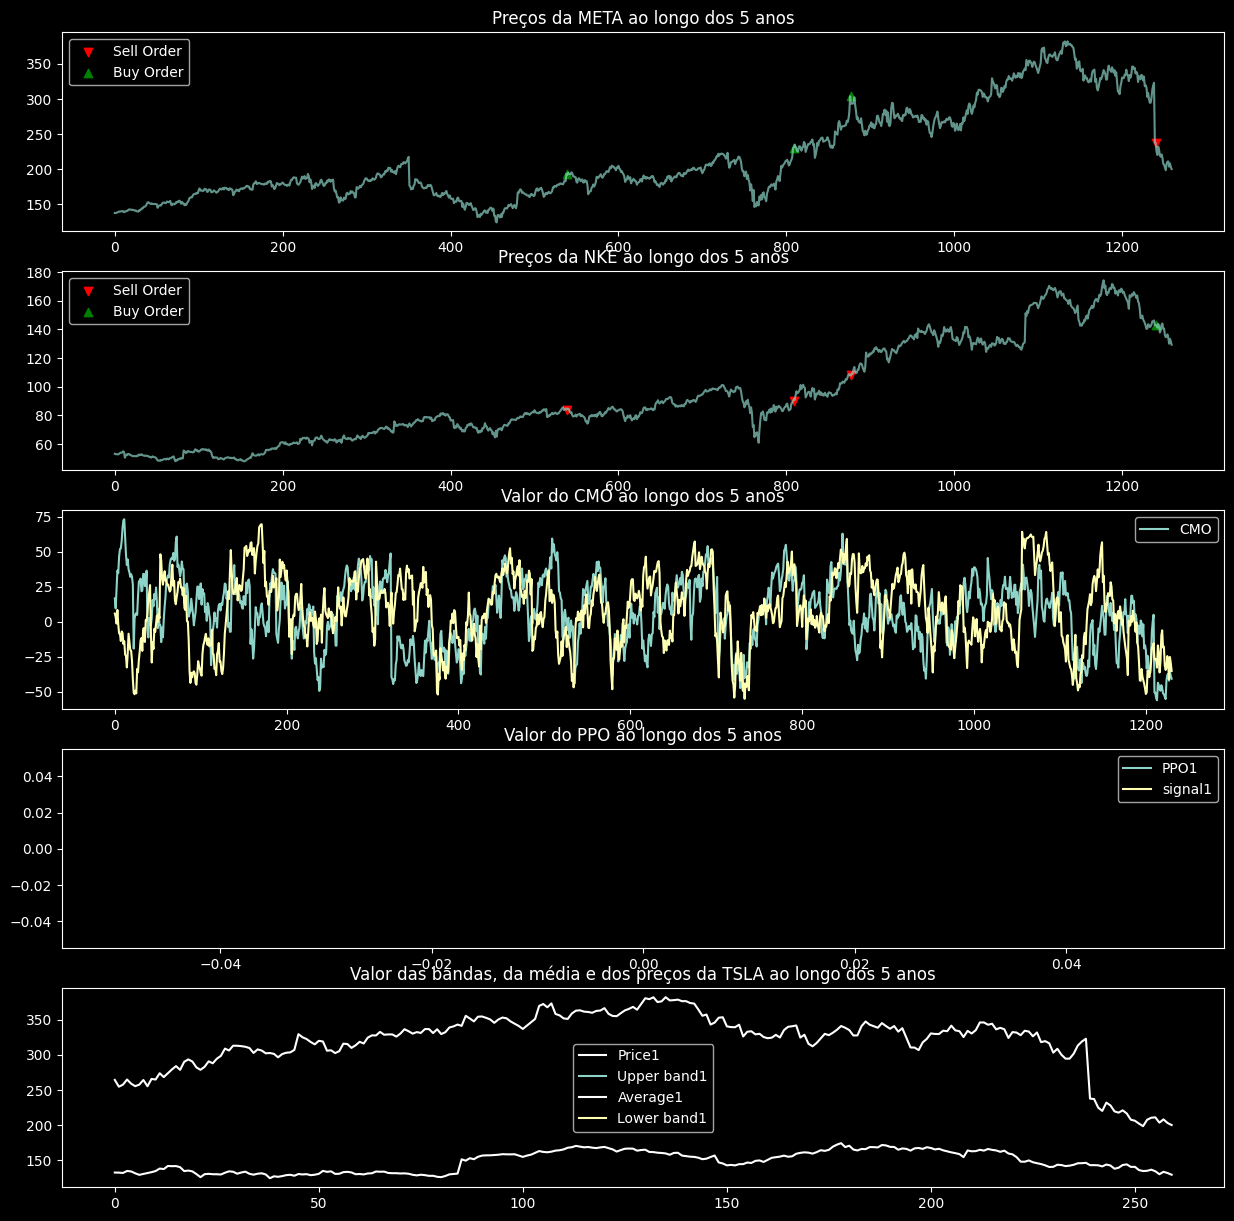

In [10]:
plt.figure(figsize=(15,5))
plt.plot([day[0] for day in fuziy_strategy._days.values()])
plt.title("Performance do capital ao longo dos 5 anos")
plt.show()

plt.figure(figsize=(15,15))

plt.subplot(5,1,1)
plt.plot(fuziy_strategy.prices1, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes1, fuziy_strategy.sell_signals1, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes1, fuziy_strategy.buy_signals1, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da META ao longo dos 5 anos")

plt.subplot(5,1,2)
plt.plot(fuziy_strategy.prices2, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes2, fuziy_strategy.sell_signals2, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes2, fuziy_strategy.buy_signals2, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da NKE ao longo dos 5 anos")

plt.subplot(5,1,3)
plt.plot(fuziy_strategy.cmo_indicator1)
plt.plot(fuziy_strategy.cmo_indicator2)
plt.legend(['CMO']);
plt.title("Valor do CMO ao longo dos 5 anos")

plt.subplot(5,1,4)
plt.plot(fuziy_strategy.ppo_indicator1)
plt.plot(fuziy_strategy.ppo_indicator2)
plt.legend(['PPO1', 'signal1', 'PPO2', 'signal2']);
plt.title("Valor do PPO ao longo dos 5 anos")

plt.subplot(5,1,5)
plt.plot(fuziy_strategy.prices1[1000:1260], color='white');
plt.plot(fuziy_strategy.bbands_indicator1[1000:1260]);
plt.plot(fuziy_strategy.prices2[1000:1260], color='white');
plt.plot(fuziy_strategy.bbands_indicator2[1000:1260]);
plt.legend(['Price1', 'Upper band1', 'Average1', 'Lower band1', 'Price2', 'Upper band2', 'Average2', 'Lower band2']);
plt.title("Valor das bandas, da média e dos preços da TSLA ao longo dos 5 anos")

plt.show()

___

## Resultados e Conclusão

Observando os resultados da estratégia nos três ativos pode-se tirar algumas conclusões, portanto ao observar os resultados com o ativo da TSLA houve um aumento da capital ao final dos 5 anos, muito porque as ações da Tesla tiveram uma tendência de subida em geral durante esses 5 anos, mas também existe a efetividade da estratégia, a qual realizou 77 trades no total e obteve um hitting ratio de 49.35%, portanto ele fez mais trades de perda, porém não só isso deve ser avaliado, vale ressaltar que o capital de retorno líquido foi de 81.94% no geral e 12.72% anual, dessa forma, para os ativos da TSLA, mesmo realizando mais trades de perda, pode-se dizer que as trades de ganho foram muito maiores que as trades de perda, uma vez que o `init_capital` aumentou ao final dos 5 anos. Vale lembrar que o Max Drawdown foi de -24.89 dólares o que indica que o calor que o modelo passou não foi tão grande, por conseguinte o modelo não trouxe tanto desconforto ao dono da estratégia.

Olhando para as ações do Meta e da Nike, a estratégia realizou 102 e 88 trades nos 5 anos comparando elas com a TSLA, pode-se verificar um comportamento parecido, mesmo que suas ações tiveram mais variações de preço, isso porque seus retornos de capital líquido geral e anual foram parecidos, com 74.17% geral e 11.74% anual para o Meta e 88.11% geral e 13.47% para a Nike. Da mesma forma, o Max Drawdown foi de -41.24 dólares para o Meta e -3.64 dólares para a Nike, mostrando que o dono da estratégia não passou tanto calor durante os cinco anos quando comparando os preços de fechamento e o capital inicial. Dessa forma, nos três cenários obteve-se um retorno de capital líquido positivo, ou seja, a estratégia ganhou dinheiro.

Um padrão interessante de se notar é que nos gráficos de capital na simulação dos três ativos a curva se aproxima de uma função exponencial ou linear e sem muitas variações, o que mostra mais uma vez que o dono da estratégia não passou calor e ganhou dinheiro, de forma que as posições de compra e venda não foram muito agressivas, de forma que não se identifica muitas variações no capital ao longo dos 5 anos.

___

## Melhorias

Para obter melhorias no desempenho da estratégia acredito que a melhor forma seria testar mais indicadores técnicos de outras vertentes, como volume, performance, utilidade e entre outros, dessa forma a estratégia não ficaria presa aos preços de fechamento do mercado e observaria outros preços diários, como de abertura, alta e baixa trazendo mais robustês e complexidade a estratégia, além disso, manipular os sinais de alguma outra forma ou realizar posições mais agressivas no mercado, podendo atender outros possíveis usuários da estratégia e podendo atingir resultados mais razoáveis de ganho de capital. 